# MAPAS DE VELOCIDAD

Junto a este notebook estoy enviando dos mapas de velocidad de galaxias, uno creado a partir de una simulación computacional, y el otro observado en una galaxia real. Aquí debajo les muestro cómo pueden leer los datos en ambos casos. El objetivo ahora es ajustar un modelo a estos mapas de velocidad, con las consideraciones exploradas antes. Es decir, hallar el mejor conjunto de parámetros: (Vsys, incl, phi_0, Vt, rt), de manera que al crear ese modelo, y compararlo a los datos, el residuo entre ambos sea lo más pequeño posible.  

No les digo más por ahora y dejo que exploren con las ideas y herramientas que ya poseen. Cuando tengan su solución me la muestran y conversamos para profundizar.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
import scipy.optimize as optimize

(160, 160)


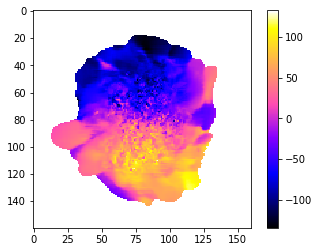

In [2]:
# En este primer caso los datos de la velocidad están simplemente almacenados
# como una matriz en un archivo txt
v = np.loadtxt("velmap.txt")
print(v.shape)
plt.imshow(v,cmap="gnuplot2")
plt.colorbar()

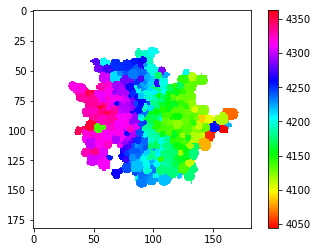

In [3]:
# En este caso los datos vienen empaquetados en el format .fits,
# que es el estándar en astronomía. La principal diferencia es que
# además de los datos de velocidad viene un header con un montón de 
# metadatos adicionales, pero que no vamos a usar aun en este punto.

# Aquí están las líneas para leer el archivo. Si examinan la variable
# hdu[0].data, esa es simplemente una matriz de numpy, así que esos son
# realmente los datos de velocidad que necesitan ajustar

hdu = fits.open("ugc4555_rv_voro.fits")
velmap = hdu[0].data
plt.imshow(velmap,cmap="hsv",interpolation=None)
plt.colorbar()

In [4]:
# Lo que sigue es simplemente un ejemplo de como yo suelo construir
# la matriz de ángulos polares Psi. No más para que comparen con su
# método a ver qué solución adoptamos luego como la más fina

In [5]:
# En este ejemplo se ilustra la creación de los arrays R,Psi,
# para analizar una imagen hipotética de 100 x 100 pixeles.
# Asegúrese de entender el significado de cada línea muy bien

# creamos los vectores con las coordenadas x,y
x = np.arange(100)
y = np.arange(100)
# Array de coordenadas x,y, un elemento por cada pixel en la imagen
yy,xx = np.meshgrid(x,y)
# definimos la posición central del array en pixels
xc,yc = 49.5,49.5
# Usamos las definiciones para R,Psi
R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
Psi = np.arctan((yy-yc)/(xx-xc))
# En la siguiente línea convertimos radianes a grados
# para facilitar la interpretación del resultado
# ATENCIÓN: las sumas establecen un rango de 0 a 360 grados,
# PERO la posición del 0 pueden no corresponder a la misma
# convención utilizada para reportar los position angle
Psi = np.rad2deg(Psi) + 90
Psi[50:,:] = Psi[50:,:]+180

# Visualice las matrices R,Psi. Son lo que esperaba?
# Construya los arrays alpha,r a partir de R,Psi.
# Deproyecte el mapa de velocidades observado, V_los,
# para obtener el mapa de velocidades circulares, V_circ

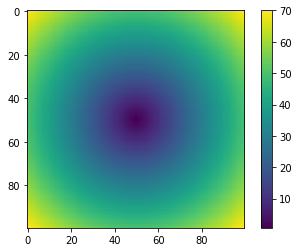

In [6]:
plt.imshow(R)
plt.colorbar()

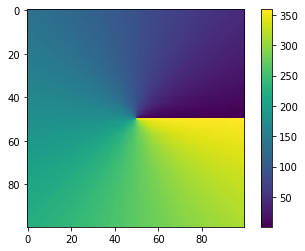

In [7]:
plt.imshow(Psi)
plt.colorbar()

# Tarea 2

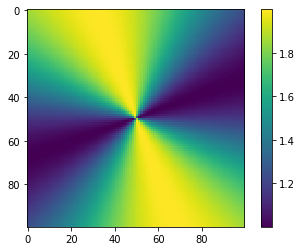

In [8]:
Psi_0 = 20
incl = 60
alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
plt.imshow(alpha)
plt.colorbar()

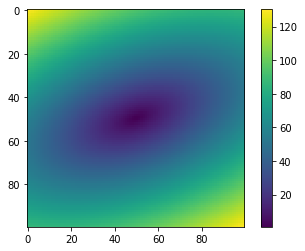

In [9]:
plt.imshow(R*alpha)
plt.colorbar()

In [18]:
def obs_vel_map(xx, r_max, r_t, v_t, incl, Psi_0, v_sys):
    """
    Function to calculate the circular velocity in each radius of the galaxy according 
    to the simplest model of a galaxy's rotation curve (velocity grows linearly at the 
    beginning and then is constant).
    
    Parameters:
    -----------
    y_x : Square matrix
    r_max : Maximum radius of the galaxy (limits)
    r_t : Distance at which the galaxy reaches the maximum speed
    v_t : Maximum speed of the galaxy
    incl :  inclination angle
    Psi_0 : position angle
    v_sys : systemic velocity
    
    Return:
    ----------
    v_los : Matrix of galaxy velocity along the line of sight
    """ 
    #x = np.arange(npix)
    # Array of x,y coordinates, an element for each pixel in the image
    #y = x
    #yy,xx = np.meshgrid(x,y)
    yy = xx.transpose()
    #xx = data[0]
    #yy = data[1]
    npix = yy.shape[0]
    # central position of the array
    xc,yc = npix/2 -0.5, npix/2 -0.5
    # R and Psi matrix
    R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
    Psi = np.arctan((yy-yc)/(xx-xc))
    Psi = np.rad2deg(Psi) + 90
    Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
    # alpha and r matrix            
    alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
    r = R*alpha  # Real radius in galaxy in pixels calculated from the projection of them

    #Conversion factor from pixels to radius
    #pix2r = r_max/(npix/(2*np.cos(Psi_0*np.pi/180)))
    #r = r_pix*pix2r  #Distance in the units of the radius
                
    v_cir = -v_t*np.e**(-r/r_t)+v_t  
    #v_cir[r > r_max] = -0.001#'nan'     # If you want that outside the galaxy the matrix has nan values  
          

    v_los = v_sys + (v_cir/alpha)*np.sin(incl*np.pi/180)*np.cos((Psi-Psi_0)*np.pi/180)
    v_los[r > r_max] =  v_sys #'nan'#v_sys #v_los.max()#'nan'
             
    return v_los.ravel()

[ 60.           9.36626773 246.61477184  18.31393324 276.46496982
  -3.3606885 ]


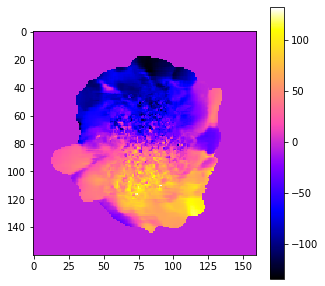

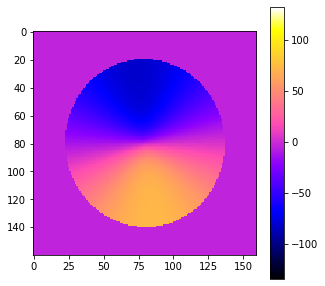

In [19]:
v = np.loadtxt("velmap.txt")
v_max = np.nanmax(v)
v_min = np.nanmin(v)
v[np.isnan(v)]= np.nanmean(v)   #nan values are changed for the mean value of the matrix

x = np.arange(160) #number of rows of data
y = np.arange(160) #number of columns of data
yy,xx = np.meshgrid(x,y)

fig = plt.figure(figsize=(5, 5))
plt.imshow(v,cmap="gnuplot2")
plt.colorbar()

#I try to avoid nan values with check_finite= False, but it didn't work 
popt,pconv = optimize.curve_fit(obs_vel_map, xx, v.ravel(), bounds = ([40, 5, 100, -90, 200, -10], [80, 80, 500, 90, 360, 5]), method = 'trf') 
print(popt) 

fig = plt.figure(figsize=(5, 5))
plt.imshow(obs_vel_map(xx, *popt).reshape(160, 160),cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

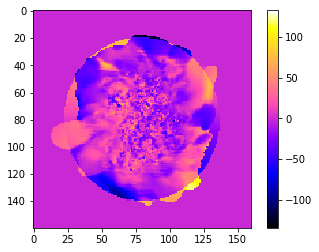

In [20]:
res = v - obs_vel_map(xx, *popt).reshape(160, 160)
plt.imshow(res,cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

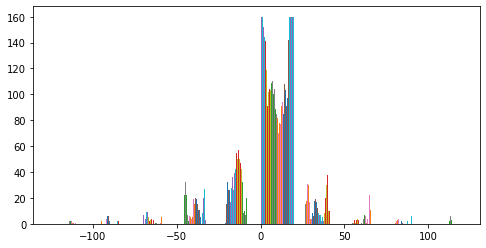

In [21]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4))
ax1.hist(res)
plt.show()

[  62.5          45.2469792   262.85318776   30.75825197  173.4111547
 4220.26094556]


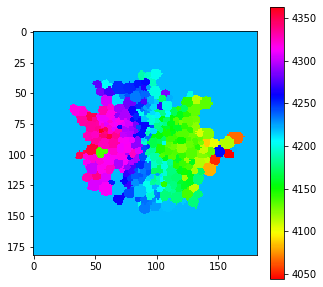

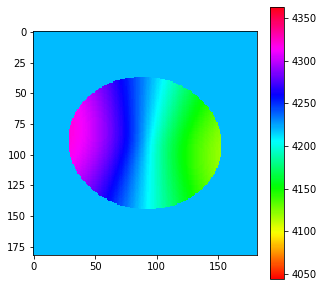

In [22]:
hdu = fits.open("ugc4555_rv_voro.fits")
velmap = hdu[0].data
v_max = np.nanmax(velmap)
v_min = np.nanmin(velmap)

velmap[np.isnan(velmap)]= np.nanmean(velmap) #v_max
fig = plt.figure(figsize=(5, 5))
plt.imshow(hdu[0].data,cmap="hsv",interpolation=None)
plt.colorbar()

x = np.arange(182)
y = np.arange(182)
yy,xx = np.meshgrid(x,y)
                                             #[60, 32, 250, 15, 180, 4200]
popt2,pconv2 = optimize.curve_fit(obs_vel_map, xx, velmap.ravel(), bounds = ([40, 15, 200, 25, 100, 4150], [85, 60, 350, 60, 200, 4350]), method = 'trf') #, [60, 10, 100,60,90, 0]
print(popt2) 

fig = plt.figure(figsize=(5, 5))
plt.imshow(obs_vel_map(xx, *popt2).reshape(182, 182),cmap="hsv", vmax = v_max, vmin = v_min)
plt.colorbar()

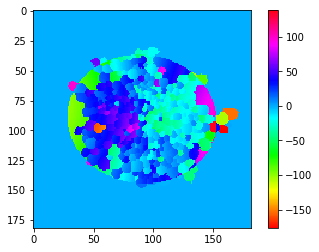

In [23]:
res2 = velmap - obs_vel_map(xx, *popt2).reshape(182, 182)
plt.imshow(res2, cmap="hsv")
plt.colorbar()

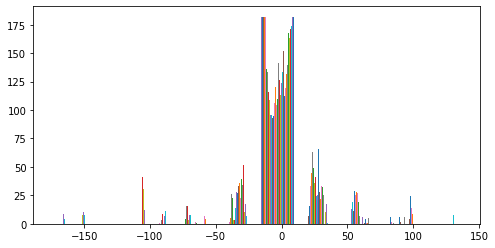

In [24]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4))
ax1.hist(res2)
plt.show()

In [25]:
x = np.arange(160)
y = np.arange(160)
yy,xx = np.meshgrid(x,y)

v = np.loadtxt("velmap.txt")
v_max = np.nanmax(v)
v_min = np.nanmin(v)
#v[np.isnan(v)]= v_max                            #[60, 55, 250, -30, 90, -3]

popt,pconv = optimize.curve_fit(obs_vel_map, xx, v.ravel(), check_finite= False, bounds = ([40, 20, 200, 0, 200, -5], [80, 60, 400, 30, 320, 0]), method = 'dogbox') 
print(popt) 

plt.imshow(obs_vel_map(xx, *popt).reshape(160, 160),cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

ValueError: Residuals are not finite in the initial point.

[ 60.  55. 250.  30. 270.  -3.]


/home/laura-pc/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


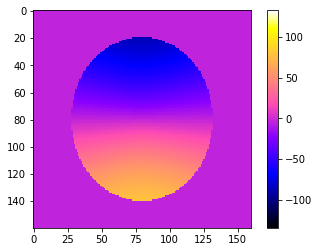

In [26]:
x = np.arange(160)
y = np.arange(160)
yy,xx = np.meshgrid(x,y)

v = np.loadtxt("velmap.txt")
v_max = np.nanmax(v)
v_min = np.nanmin(v)
#v[np.isnan(v)]= v_max                            #[60, 55, 250, -30, 90, -3]

popt,pconv = optimize.curve_fit(obs_vel_map, xx, v.ravel(), p0 = [60, 55, 250, 30, 270, -3],sigma=None,check_finite= False) 
print(popt) 

plt.imshow(obs_vel_map(xx, *popt).reshape(160, 160),cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

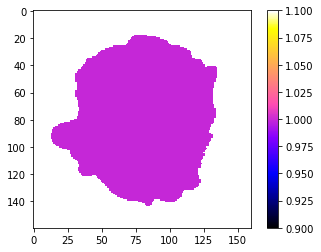

In [27]:
mask = np.where(v == np.nan, v, v*0 +1)
plt.imshow(mask,cmap="gnuplot2" )
plt.colorbar()

# Mask to avoid nan values 
It didn't work

In [45]:
def obs_vel_map(matrix, r_max, r_t, v_t, incl, Psi_0, v_sys):
    """
    Function to calculate the circular velocity in each radius of the galaxy according 
    to the simplest model of a galaxy's rotation curve (velocity grows linearly at the 
    beginning and then is constant).
    
    Parameters:
    -----------
    y_x : Square matrix
    r_max : Maximum radius of the galaxy (limits)
    r_t : Distance at which the galaxy reaches the maximum speed
    v_t : Maximum speed of the galaxy
    incl :  inclination angle
    Psi_0 : position angle
    v_sys : systemic velocity
    
    Return:
    ----------
    v_los : Matrix of galaxy velocity along the line of sight
    """ 
    #x = np.arange(npix)
    # Array of x,y coordinates, an element for each pixel in the image
    #y = x
    #yy,xx = np.meshgrid(x,y)
    xx =  matrix[0]
    mask = matrix[1]
    yy = xx.transpose()
    #xx = data[0]
    #yy = data[1]
    npix = yy.shape[0]
    # central position of the array
    xc,yc = npix/2 -0.5, npix/2 -0.5
    # R and Psi matrix
    R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
    Psi = np.arctan((yy-yc)/(xx-xc))
    Psi = np.rad2deg(Psi) + 90
    Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
    # alpha and r matrix            
    alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
    r = R*alpha  # Real radius in galaxy in pixels calculated from the projection of them

    #Conversion factor from pixels to radius
    #pix2r = r_max/(npix/(2*np.cos(Psi_0*np.pi/180)))
    #r = r_pix*pix2r  #Distance in the units of the radius
                
    v_cir = -v_t*np.e**(-r/r_t)+v_t  
    #v_cir[r > r_max] = -0.001#'nan'     # If you want that outside the galaxy the matrix has nan values  
          

    v_los = v_sys + (v_cir/alpha)*np.sin(incl*np.pi/180)*np.cos((Psi-Psi_0)*np.pi/180)
    v_los[r > r_max] =  'nan'#v_sys #v_los.max()#'nan'
    v_los = v_los*mask
    v_los = v_los[~np.isnan(mask)]
    
    return v_los.ravel()

In [46]:
def obs_vel_map4plot(xx, r_max, r_t, v_t, incl, Psi_0, v_sys):
    """
    Function to calculate the circular velocity in each radius of the galaxy according 
    to the simplest model of a galaxy's rotation curve (velocity grows linearly at the 
    beginning and then is constant).
    
    Parameters:
    -----------
    y_x : Square matrix
    r_max : Maximum radius of the galaxy (limits)
    r_t : Distance at which the galaxy reaches the maximum speed
    v_t : Maximum speed of the galaxy
    incl :  inclination angle
    Psi_0 : position angle
    v_sys : systemic velocity
    
    Return:
    ----------
    v_los : Matrix of galaxy velocity along the line of sight
    """ 
    #x = np.arange(npix)
    # Array of x,y coordinates, an element for each pixel in the image
    #y = x
    #yy,xx = np.meshgrid(x,y)
    yy = xx.transpose()
    #xx = data[0]
    #yy = data[1]
    npix = yy.shape[0]
    # central position of the array
    xc,yc = npix/2 -0.5, npix/2 -0.5
    # R and Psi matrix
    R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
    Psi = np.arctan((yy-yc)/(xx-xc))
    Psi = np.rad2deg(Psi) + 90
    Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
    # alpha and r matrix            
    alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
    r = R*alpha  # Real radius in galaxy in pixels calculated from the projection of them

    #Conversion factor from pixels to radius
    #pix2r = r_max/(npix/(2*np.cos(Psi_0*np.pi/180)))
    #r = r_pix*pix2r  #Distance in the units of the radius
                
    v_cir = -v_t*np.e**(-r/r_t)+v_t  
    #v_cir[r > r_max] = -0.001#'nan'     # If you want that outside the galaxy the matrix has nan values  
          

    v_los = v_sys + (v_cir/alpha)*np.sin(incl*np.pi/180)*np.cos((Psi-Psi_0)*np.pi/180)
    v_los[r > r_max] =  'nan'#v_sys #v_los.max()#'nan'
             
    return v_los.ravel()

[ 60.  55. 250.  30. 270.  -3.]


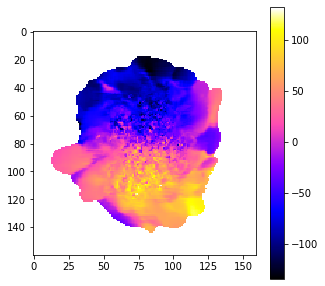

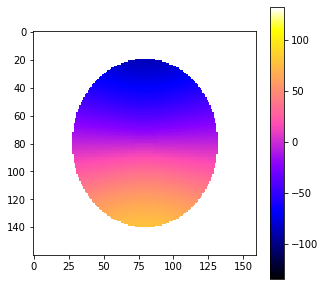

In [49]:
x = np.arange(160)
y = np.arange(160)
yy,xx = np.meshgrid(x,y)

v = np.loadtxt("velmap.txt")
fig = plt.figure(figsize=(5, 5))
plt.imshow(v,cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()
v_max = np.nanmax(v)
v_min = np.nanmin(v)
mask = v/v                           #[60, 55, 250, -30, 90, -3]

popt,pconv = optimize.curve_fit(obs_vel_map, [xx, mask], v[~np.isnan(v)], p0 = [60, 55, 250, 30, 270, -3],sigma=None,check_finite= False) 
print(popt) 

fig = plt.figure(figsize=(5, 5))
fit = obs_vel_map4plot(xx, *popt).reshape(160, 160)
fit[fit ==0]= 'nan' 
plt.imshow(fit,cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

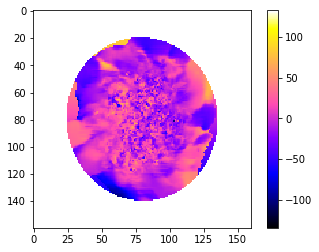

In [30]:
res = v - fit
plt.imshow(res,cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

/home/laura-pc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6735: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/laura-pc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6736: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


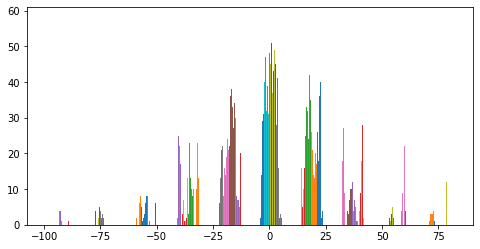

In [31]:
fig, ax1 = plt.subplots(1,1, figsize=(8,4))
ax1.hist(res)
plt.show()